In [22]:
import sys
import gym
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple
import time
import configparser

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical

import virtualTB

env = gym.make('VirtualTB-v0')
env_action_space = env.action_space.shape[0]

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) # stack for each element
        ''' 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)

        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

nn.LayerNorm = LayerNorm
    
    
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, init_w=3e-3):
        super(ActorNetwork, self).__init__()

        self.saved_logprobs = [] # this is critical! have to save the values inside the model to keep track of its gradients
        self.saved_entropies = []

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        
        self.mean_linear = nn.Linear(hidden_dim, output_dim) # output dim = dim of action
        self.log_std_linear = nn.Linear(hidden_dim, output_dim)

        # weights initialization
#         self.mean_linear.weight.data.uniform_(-init_w, init_w)
#         self.mean_linear.bias.data.uniform_(-init_w, init_w)
#         self.log_std_linear.weight.data.uniform_(-init_w, init_w)
#         self.log_std_linear.bias.data.uniform_(-init_w, init_w)

        self.mean_linear.weight.data.mul_(0.1)
        self.mean_linear.bias.data.mul_(0.1)
        self.log_std_linear.weight.data.mul_(0.1)
        self.log_std_linear.bias.data.mul_(0.1)
        

    def forward(self, state):
        x = self.linear1(state)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)

        self.log_std_min=-20
        self.log_std_max=2

        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mean, log_std

    def select_action(self, state):
        '''
        only select action without the purpose of gradients flow, for interaction with env to
        generate samples
        '''

        self.action_range = 1.

        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(0, 1)
        z = normal.sample().to(device)
        action = self.action_range* torch.tanh(mean + std*z)
 
        return action.detach()


    def evaluate_action(self, state):
        '''
        evaluate action within GPU graph, for gradients flowing through it
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # state dim: (N, dim of state)

        self.action_range = 1.
        self.epsilon = 1e-5

        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(0, 1)
        z = normal.sample().to(device)
        action0 = torch.tanh(mean + std*z.to(device)) # TanhNormal distribution as actions; reparameterization trick
        action = self.action_range * action0

        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1. - action0.pow(2) + self.epsilon) -  np.log(self.action_range)            
        log_prob = log_prob.sum(dim=1, keepdim=True)
        # print('mean: ', mean, 'log_std: ', log_std)
        # return action.item(), log_prob, z, mean, log_std
        return action.clamp(-1, 1).detach().cpu().numpy().squeeze(0), log_prob.squeeze(0), Normal(mean, std).entropy().mean()

class CriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, init_w=3e-3):
        super(CriticNetwork, self).__init__()

        self.saved_values = [] # this is critical! have to save the values inside the model to keep track of its gradients
        self.saved_nextvalues = []
    
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        state = torch.FloatTensor(state).to(device)
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
            
env.close()

In [23]:
def Update0(rewards, gamma=0.99, entropy_lambda=1e-3): 
    ''' update with R(s') instead of V(s') in the TD-error;
        with entropy boosting exploration
    '''
    R = 0
    policy_losses = []
    value_losses = []
    rewards_ = []
    eps = np.finfo(np.float32).eps.item()

    for r in rewards[::-1]:
        R = r + gamma * R
        rewards_.insert(0, R)
    rewards_ = torch.tensor(rewards_).to(device)
    rewards_ = (rewards_ - rewards_.mean()) / (rewards_.std() + eps)
    # print('rewards: ', rewards)
    # print('rewards_: ', rewards_)
    for log_prob, value, r in zip(actor.saved_logprobs, critic.saved_values, rewards_):
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).to(device)))
        td_error = r - value.detach().item() # value gradients flow only through the critic
        policy_losses.append(-log_prob * td_error)
    # print('policy losses: ', policy_losses)
    # print('value losses: ', value_losses)
    actor_optimizer.zero_grad()
    policy_loss=torch.stack(policy_losses).sum() - entropy_lambda * torch.stack(actor.saved_entropies).sum()
    policy_loss.backward()
    actor_optimizer.step()
    critic_optimizer.zero_grad()
    value_loss=torch.stack(value_losses).sum()
    value_loss.backward()
    # print('loss: ', policy_loss, value_loss)
    critic_optimizer.step()
    del actor.saved_logprobs[:]
    del critic.saved_values[:]
    del actor.saved_entropies[:]
    
    return policy_losses, value_losses

def Update1(rewards, gamma=0.99): 
    ''' update with V(s') in the TD-error'''
    policy_losses = []
    value_losses = []
    value_criterion  = nn.MSELoss()

    rewards = torch.tensor(rewards).to(device)
    for log_prob, state_value, next_state_value, r in zip(actor.saved_logprobs, critic.saved_values, critic.saved_nextvalues, rewards):
        value_losses.append(value_criterion(state_value, r + gamma * next_state_value.detach_()))
        state_value.detach_() # detach in place
        policy_losses.append(-log_prob * (r + gamma * next_state_value - state_value)) # only BP through the log_prob for actor update
    # print('policy losses: ', policy_losses)
    # print('value losses: ', value_losses)
    actor_optimizer.zero_grad()
    policy_loss=torch.stack(policy_losses).sum()
    policy_loss.backward()
    actor_optimizer.step()
    critic_optimizer.zero_grad()
    value_loss=torch.stack(value_losses).sum()
    value_loss.backward()
    # print('loss: ', policy_loss, value_loss)
    critic_optimizer.step()
    del actor.saved_logprobs[:]
    del critic.saved_values[:]
    del critic.saved_nextvalues[:]
    
    return policy_losses, value_losses

In [24]:
class NormalizedActions(gym.ActionWrapper): # gym env wrapper
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action

In [25]:
from gym import wrappers
from copy import deepcopy
import pickle
import matplotlib
import matplotlib.pyplot as plt

FLOAT = torch.FloatTensor
LONG = torch.LongTensor
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

Transition = namedtuple(
    'Transition', ('state', 'action', 'mask', 'next_state', 'reward'))

# env = NormalizedActions(gym.make('VirtualTB-v0'))
env = gym.make('VirtualTB-v0')

env.seed(0)
np.random.seed(0)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 128

actor = ActorNetwork(state_dim, action_dim, hidden_dim).to(device)
critic = CriticNetwork(state_dim, hidden_dim).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-5)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-4)

memory = ReplayBuffer(10000)

rewards = []
test_reward_record = []
ctr_record = []
reward_record = []
value_loss_record = []
policy_loss_record = []

total_numsteps = 0
updates = 0
test_ep = 100

UPDATE = 'V'
ON_POLICY = True


for i_episode in range(10000):
    state = torch.Tensor([env.reset()])

    episode_reward = 0
    while True:
        action, log_prob, entropy = actor.evaluate_action(state)
        V = critic(state)
#         print(action)
        next_state, reward, done, _ = env.step(action[0])
        next_V = critic(next_state)
        actor.saved_entropies.append(entropy)

        if UPDATE == 'R':
            actor.saved_logprobs.append(log_prob)
            critic.saved_values.append(V)
        if UPDATE == 'V':
            actor.saved_logprobs.append(log_prob)
            critic.saved_values.append(V)
            critic.saved_nextvalues.append(next_V)

        total_numsteps += 1
        episode_reward += reward
        reward_record.append(reward)

#         action = torch.Tensor(action.cpu())
#         mask = torch.Tensor([not done])
        next_state = torch.Tensor([next_state])
#         reward = torch.Tensor([reward])

#         memory.push(state.to(device), action.to(device), reward.to(device), next_state.to(device), mask.to(device))

        state = next_state

        # 可以加提前终止的机制

        if done:
            break
            
    if UPDATE == 'R':
        policy_loss_record, value_loss_record = Update0(reward_record)
    if UPDATE == 'V':
        policy_loss_record, value_loss_record = Update1(reward_record)
    
            
#     if i_episode >= 20 and i_episode % 10 == 0:
#         for _ in range(10):
#             transitions = memory.sample(128)
#             batch = Transition(*zip(*transitions))

#             value_loss, policy_loss = agent.update_parameters(batch)
#             value_loss_record.append(value_loss)
#             policy_loss_record.append(policy_loss)

#             updates += 1
            
    rewards.append(episode_reward)
    
    
    if i_episode % test_ep == 0:
        episode_reward = 0
        episode_step = 0
        for i in range(50):
            state = torch.Tensor([env.reset()])
            while True:
                if i == 0:
                    print(action)
                action, log_prob, entropy = actor.evaluate_action(state)

                next_state, reward, done, info = env.step(action[0])
                episode_reward += reward
                episode_step += 1

                next_state = torch.Tensor([next_state])

                state = next_state
                if done:
                    break

        # rewards.append(episode_reward)
        test_reward_record.append(episode_reward / 50)
        ctr_record.append(episode_reward / episode_step/ 10)
        print("Episode: {}, total numsteps: {}, average reward: {}, CTR: {}".format(i_episode, episode_step, episode_reward / 50, episode_reward / episode_step/ 10))
    
env.close()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


[[-0.588207   -0.5784553  -0.5847495  ... -0.5800562  -0.5773034
  -0.58442324]
 [-0.59757125 -0.59494644 -0.58532065 ... -0.5500479  -0.58688295
  -0.62050337]
 [-0.59051514 -0.5825243  -0.5848641  ... -0.5728221  -0.57957375
  -0.5934959 ]
 ...
 [-0.5866101  -0.57580745 -0.58489484 ... -0.58503664 -0.575948
  -0.57830894]
 [-0.58874226 -0.5750883  -0.5840889  ... -0.5830667  -0.5758309
  -0.5795764 ]
 [-0.59511244 -0.58721125 -0.58335    ... -0.56034327 -0.58201456
  -0.60624397]]
[[0.485937   0.48638216 0.47721466 ... 0.48412672 0.48875305 0.48437747]
 [0.49744397 0.45092946 0.47250608 ... 0.51798105 0.4974646  0.4363404 ]
 [0.48878294 0.47768983 0.47607133 ... 0.49257872 0.49083763 0.47279048]
 ...
 [0.48409137 0.49224916 0.47812483 ... 0.4784109  0.48711276 0.49214417]
 [0.48316094 0.49008814 0.477151   ... 0.48171997 0.48808533 0.48875636]
 [0.49175325 0.4640805  0.473144   ... 0.5059878  0.49609625 0.4540056 ]]
[[-0.5289611  -0.51579845 -0.5303825  ... -0.522453   -0.51223505
  

Episode: 100, total numsteps: 500, average reward: 3.1, CTR: 0.031
[[-0.5578061  -0.5484748  -0.55474174 ... -0.5499619  -0.54704154
  -0.55366397]
 [-0.58946097 -0.5908989  -0.5803364  ... -0.5446888  -0.582286
  -0.6103616 ]
 [-0.5656253  -0.55913126 -0.5608913  ... -0.54853326 -0.5555866
  -0.5680394 ]
 ...
 [-0.5524449  -0.54121935 -0.5509435  ... -0.55102193 -0.5414587
  -0.54378545]
 [-0.5550921  -0.5420126  -0.5511123  ... -0.5500231  -0.54222727
  -0.5462867 ]
 [-0.5784035  -0.5738268  -0.56778485 ... -0.54582727 -0.5670223
  -0.58891714]]
[[0.96330416 0.96215576 0.9623675  ... 0.96061397 0.961398   0.9644224 ]
 [0.96732825 0.95725805 0.9692409  ... 0.95727575 0.95885247 0.97101825]
 [0.9643156  0.9610056  0.9641515  ... 0.95980036 0.9607769  0.966117  ]
 ...
 [0.9626297  0.9628953  0.96114385 ... 0.96116394 0.9617972  0.96326935]
 [0.9628597  0.9624892  0.96142673 ... 0.9613727  0.9617563  0.9634403 ]
 [0.96571237 0.95923    0.96658975 ... 0.9587876  0.95999634 0.9683685 ]]
[[

Episode: 300, total numsteps: 500, average reward: 4.26, CTR: 0.0426
[[-0.9419768  -0.9375426  -0.9401338  ... -0.9391745  -0.9395945
  -0.9397869 ]
 [-0.9546166  -0.94050676 -0.9510555  ... -0.9449441  -0.95701003
  -0.94986016]
 [-0.94530284 -0.93828046 -0.94294727 ... -0.9405668  -0.9442057
  -0.9424211 ]
 ...
 [-0.9396625  -0.93709713 -0.93827534 ... -0.9383402  -0.93642783
  -0.9379769 ]
 [-0.9405745  -0.936866   -0.9384225  ... -0.9385544  -0.93701535
  -0.93838614]
 [-0.9500475  -0.9388119  -0.94626564 ... -0.9421137  -0.95016086
  -0.94593334]]
[[-0.9292528  -0.9239966  -0.9268299  ... -0.92393637 -0.925506
  -0.92587525]
 [-0.9412098  -0.9239053  -0.9345992  ... -0.9132862  -0.93792397
  -0.9306619 ]
 [-0.93234307 -0.9239788  -0.9287579  ... -0.92145205 -0.9286704
  -0.927073  ]
 ...
 [-0.9270656  -0.9240498  -0.92553735 ... -0.925574   -0.92332304
  -0.9250655 ]
 [-0.92802477 -0.923673   -0.9258114  ... -0.92544484 -0.9238242
  -0.9253788 ]
 [-0.9371903  -0.92345905 -0.931476

Episode: 500, total numsteps: 500, average reward: 3.5, CTR: 0.034999999999999996
[[-0.14235397 -0.13387737 -0.13870506 ... -0.13277173 -0.12490959
  -0.13713247]
 [-0.17606787 -0.19956978 -0.14121318 ... -0.0999075  -0.11910894
  -0.20989846]
 [-0.15055169 -0.15008585 -0.13929006 ... -0.12475412 -0.12342201
  -0.15509208]
 ...
 [-0.1367109  -0.12305709 -0.13853574 ... -0.13840365 -0.12597595
  -0.12512778]
 [-0.14024486 -0.12408332 -0.13839775 ... -0.1348765  -0.12531327
  -0.1278064 ]
 [-0.16510046 -0.17207153 -0.13864234 ... -0.10986769 -0.12094879
  -0.1806089 ]]
[[-0.84946775 -0.8419905  -0.84798884 ... -0.843024   -0.8395047
  -0.8513378 ]
 [-0.8640066  -0.84510833 -0.86553866 ... -0.83193207 -0.83296597
  -0.89449584]
 [-0.8530483  -0.842726   -0.85240114 ... -0.8403388  -0.83792216
  -0.86289674]
 ...
 [-0.8470144  -0.8415638  -0.84495205 ... -0.84497356 -0.84063697
  -0.84335405]
 [-0.84815127 -0.8411559  -0.8455659  ... -0.84453636 -0.84049505
  -0.84565866]
 [-0.858878   -0.

Episode: 700, total numsteps: 500, average reward: 3.22, CTR: 0.0322
[[-0.9392118  -0.9353378  -0.9373541  ... -0.9359511  -0.9362229
  -0.937387  ]
 [-0.9505716  -0.9406394  -0.94699025 ... -0.9373282  -0.9499361
  -0.9484536 ]
 [-0.94215965 -0.936671   -0.9397913  ... -0.93626404 -0.939775
  -0.94028324]
 ...
 [-0.9371427  -0.9344975  -0.9357338  ... -0.9357789  -0.9338044
  -0.9353937 ]
 [-0.93800116 -0.9343203  -0.93598497 ... -0.9358215  -0.9343092
  -0.93578494]
 [-0.94661826 -0.93796617 -0.9429431  ... -0.9366019  -0.94451
  -0.9441136 ]]
[[-0.05181836 -0.04532458 -0.05480325 ... -0.05147074 -0.03626768
  -0.05483465]
 [-0.04978341 -0.08391638 -0.05565596 ... -0.03339747 -0.0021834
  -0.141243  ]
 [-0.05129969 -0.0547643  -0.0550064  ... -0.04709057 -0.02796657
  -0.07604106]
 ...
 [-0.05200434 -0.03879957 -0.05470832 ... -0.05463978 -0.04200466
  -0.04057037]
 [-0.05429129 -0.04174628 -0.05450643 ... -0.05212317 -0.04021094
  -0.04403318]
 [-0.05290738 -0.0705156  -0.0550078  .

Episode: 900, total numsteps: 500, average reward: 3.36, CTR: 0.033600000000000005
[[0.8175744  0.8132874  0.81691694 ... 0.8161955  0.8203871  0.81641877]
 [0.8265048  0.7777194  0.8455269  ... 0.83988893 0.84932214 0.7967025 ]
 [0.81977624 0.8050922  0.82415366 ... 0.822192   0.82768565 0.8117675 ]
 ...
 [0.8162002  0.81875646 0.8119349  ... 0.8120774  0.81551653 0.8194519 ]
 [0.816115   0.8173865  0.8128716  ... 0.8142747  0.81677043 0.81877375]
 [0.8220492  0.7913625  0.8346306  ... 0.8315519  0.8375963  0.8048793 ]]
[[-0.8077376  -0.7974818  -0.80182177 ... -0.8005281  -0.7930739
  -0.806022  ]
 [-0.83586574 -0.8050331  -0.8085528  ... -0.7994249  -0.7787324
  -0.8485314 ]
 [-0.81480646 -0.79935443 -0.8034887  ... -0.8002616  -0.7895989
  -0.8169851 ]
 ...
 [-0.8029684  -0.7963177  -0.80074143 ... -0.80080307 -0.7954607
  -0.7983416 ]
 [-0.8043213  -0.7954582  -0.80082154 ... -0.7999718  -0.79494524
  -0.80005926]
 [-0.8248483  -0.8008247  -0.805509   ... -0.7988367  -0.78404117
 

Episode: 1100, total numsteps: 500, average reward: 3.44, CTR: 0.0344
[[-0.5956564  -0.58782065 -0.59098095 ... -0.5863061  -0.58534575
  -0.59175646]
 [-0.6257886  -0.6358289  -0.60674655 ... -0.5729395  -0.62047744
  -0.64653194]
 [-0.60307723 -0.5999762  -0.59470636 ... -0.58298886 -0.5938882
  -0.60567814]
 ...
 [-0.59049374 -0.5796679  -0.58870995 ... -0.58871746 -0.5797292
  -0.5822369 ]
 [-0.5937975  -0.57986283 -0.589128   ... -0.5871796  -0.58044434
  -0.58451736]
 [-0.6163119  -0.61540353 -0.5992701  ... -0.57667637 -0.6056024
  -0.62553596]]
[[0.84305364 0.83855945 0.83646536 ... 0.83403736 0.8378551  0.8454529 ]
 [0.8578416  0.81136364 0.837314   ... 0.8183669  0.8263476  0.8586575 ]
 [0.8467186  0.8322234  0.8366662  ... 0.8302418  0.83503616 0.8485154 ]
 ...
 [0.8405748  0.8426331  0.83652246 ... 0.8366067  0.8396428  0.843458  ]
 [0.84085125 0.8408062  0.8363734  ... 0.83696187 0.8399458  0.84369254]
 [0.8518899  0.8224127  0.83566463 ... 0.8251091  0.8319846  0.8531043 

Episode: 1300, total numsteps: 500, average reward: 3.38, CTR: 0.033800000000000004
[[-0.30136892 -0.29295975 -0.29800722 ... -0.29314598 -0.28611875
  -0.29684815]
 [-0.3358377  -0.35796794 -0.31299877 ... -0.276944   -0.30015132
  -0.3692594 ]
 [-0.3097776  -0.3091433  -0.3015652  ... -0.28914556 -0.28938353
  -0.3149133 ]
 ...
 [-0.2955323  -0.28212735 -0.2959574  ... -0.29596004 -0.2840187
  -0.2845566 ]
 [-0.29907608 -0.28340808 -0.2961487  ... -0.29418033 -0.28423402
  -0.28771693]
 [-0.3248924  -0.33097148 -0.30491778 ... -0.28213817 -0.29377127
  -0.34116322]]
[[-0.6130764  -0.6076603  -0.60826564 ... -0.60678715 -0.6031043
  -0.6144012 ]
 [-0.63278925 -0.65391576 -0.61223245 ... -0.5983939  -0.6255076
  -0.6853777 ]
 [-0.617964   -0.6193547  -0.60925317 ... -0.60475785 -0.60861325
  -0.632563  ]
 ...
 [-0.6097593  -0.5993936  -0.6078928  ... -0.6080492  -0.5992888
  -0.60198927]
 [-0.6122088  -0.60090363 -0.6075369  ... -0.6077486  -0.600453
  -0.60588866]
 [-0.62607026 -0.637

Episode: 1500, total numsteps: 500, average reward: 3.48, CTR: 0.0348
[[-0.48666668 -0.4766748  -0.4818133  ... -0.47805494 -0.47392043
  -0.47884953]
 [-0.5273069  -0.53106064 -0.5044006  ... -0.47588915 -0.51037425
  -0.5315445 ]
 [-0.49668932 -0.49034563 -0.487195   ... -0.47739577 -0.48272765
  -0.4920918 ]
 ...
 [-0.47969612 -0.46756187 -0.47865587 ... -0.478679   -0.46831098
  -0.47011137]
 [-0.48290887 -0.46833777 -0.47906777 ... -0.47733563 -0.4694764
  -0.4721827 ]
 [-0.5133808  -0.5080422  -0.49246967 ... -0.47485825 -0.49387342
  -0.50922555]]
[[-0.18323669 -0.17511068 -0.18469815 ... -0.18315366 -0.16914414
  -0.18011096]
 [-0.20184478 -0.2251693  -0.20103621 ... -0.19231667 -0.1685636
  -0.24697345]
 [-0.18771884 -0.18749128 -0.18866144 ... -0.18535614 -0.16897292
  -0.19652677]
 ...
 [-0.18020889 -0.16668178 -0.18188216 ... -0.18181072 -0.1693029
  -0.16888621]
 [-0.18270922 -0.16848768 -0.18335193 ... -0.18088652 -0.16921026
  -0.17237923]
 [-0.19574405 -0.20602591 -0.19

KeyboardInterrupt: 

In [ ]:
torch.save(actor,'a2c_actor.pt')
torch.save(critic,'a2c_critic.pt')
# model = torch.load('ddpg.pt')

In [3]:
with open('./rewards_record.pkl', 'wb') as f:
    pickle.dump(rewards, f)
with open('./test_reward_record.pkl', 'wb') as f:
    pickle.dump(test_reward_record, f)
with open('./ctr_record.pkl', 'wb') as f:
    pickle.dump(ctr_record, f)
with open('./reward_record.pkl', 'wb') as f:
    pickle.dump(reward_record, f)
with open('./value_loss_record.pkl', 'wb') as f:
    pickle.dump(value_loss_record, f)
with open('./policy_loss.pkl', 'wb') as f:
    pickle.dump(policy_loss_record, f)    

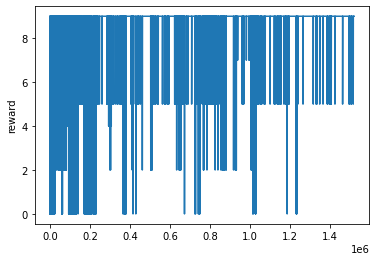

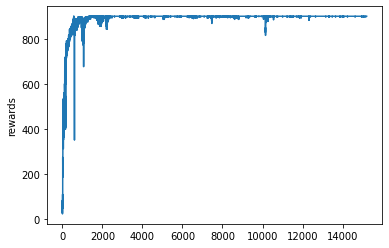

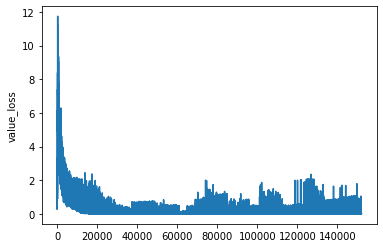

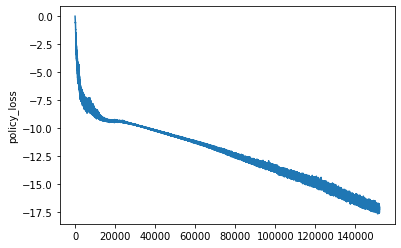

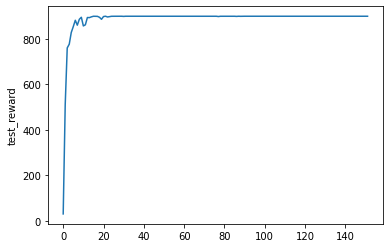

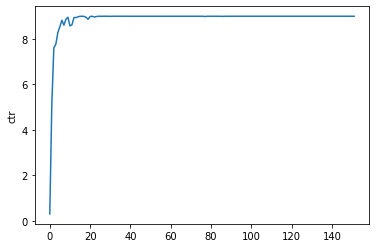

In [4]:
def getInfo():
    '''返回六个列表,分别用于保存reward/rewards/value_loss/policy_loss/test_reward/ctr'''
    info = list()
    fileNames = [
        './reward_record.pkl',
        './rewards_record.pkl',
        './value_loss_record.pkl',
        './policy_loss.pkl',
        './test_reward_record.pkl',
        './ctr_record.pkl']  # 文件的名字
    for name in fileNames:
        with open(name, 'rb') as f:
            item = pickle.load(f)
            info.append(item)
    return info

reward_record, rewards, value_loss_record, policy_loss_record, test_reward_record,ctr_record = getInfo()

plt.plot(reward_record)
plt.ylabel('reward')
plt.show()

plt.plot(rewards)
plt.ylabel('rewards')
plt.show()

plt.plot(value_loss_record)
plt.ylabel('value_loss')
plt.show()

plt.plot(policy_loss_record)
plt.ylabel('policy_loss')
plt.show()

plt.plot(test_reward_record)
plt.ylabel('test_reward')
plt.show()

plt.plot(ctr_record)
plt.ylabel('ctr')
plt.show()